# ASEWA Project - ResNet50
Using the pretrained ResNet50 to perform Style Transfer
---
Janina Klarmann, Laura Kühl

## Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import PIL.Image
import IPython.display as display

In [2]:
import tensorflow as tf
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
# tf.compat.v1.disable_eager_execution()
# print("Eager execution: {}".format(tf.executing_eagerly()))

## Images

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


## Layers

### Main Layers

In [4]:
# Content layer 
content_layers_resnet50 = ['conv1_conv']

# # # Style layer
style_layers_resnet50 = ['conv2_block2_1_bn','conv3_block2_3_bn','conv3_block3_3_conv','conv4_block2_2_bn'#,'conv1'
               ]

num_content_layers = len(content_layers_resnet50)
num_style_layers = len(style_layers_resnet50)

### Layers for Layer Selection Analysis

In [ ]:
## Last layers of blocks and content
# style_layers_resnet50 = ['conv2_block1_3_conv','conv2_block2_3_conv','conv2_block3_3_conv','conv3_block1_3_conv','conv3_block2_3_conv','conv3_block3_3_conv', 'conv4_block1_3_conv','conv4_block2_3_conv','conv4_block3_3_conv', 'conv5_block1_3_conv','conv5_block2_3_conv','conv5_block3_3_conv']
# content_layers_resnet50 = ['conv5_block3_out']

## Last style, first content
# style_layers_resnet50 = ['conv2_block1_3_conv','conv2_block2_3_conv','conv2_block3_3_conv','conv3_block1_3_conv','conv3_block2_3_conv','conv3_block3_3_conv', 'conv4_block1_3_conv','conv4_block2_3_conv','conv4_block3_3_conv', 'conv5_block1_3_conv','conv5_block2_3_conv','conv5_block3_3_conv']
# content_layers_resnet50 = ['conv1_conv']

## First style, first content
# style_layers_resnet50 = ['conv2_block1_1_conv','conv3_block1_1_conv','conv4_block1_1_conv','conv5_block1_1_conv']
# content_layer_resnet50 = ['conv1_conv']

## Second Style, first content
# style_layers_resnet50 = ['conv2_block1_2_conv','conv3_block1_2_conv','conv4_block1_2_conv','conv5_block1_2_conv']
# content_layer_resnet50 = ['conv1_conv']

## second block, first layers
# style_layers_resnet50 = ['conv2_block2_1_conv','conv3_block2_1_conv','conv4_block2_1_conv','conv5_block2_1_conv']
# content_layer_resnet50 = ['conv1_conv']

## third block, first style, first content
# style_layers_resnet50 = ['conv2_block3_1_conv','conv3_block3_1_conv','conv4_block3_1_conv','conv5_block3_1_conv']
# content_layer_resnet50 = ['conv1_conv']

## second block, second style, first content
# style_layers_resnet50 = ['conv2_block2_2_conv','conv3_block2_2_conv','conv4_block2_2_conv','conv5_block2_2_conv']
# content_layer_resnet50 = ['conv1_conv']

## second block, third style, first content
# style_layers_resnet50 = ['conv2_block2_3_conv','conv3_block2_3_conv','conv4_block2_3_conv','conv5_block2_3_conv']
# content_layer_resnet50 = ['conv1_conv']

## third block, second style, first content
# style_layers_resnet50 = ['conv2_block3_2_conv','conv3_block3_2_conv','conv4_block3_2_conv','conv5_block3_2_conv']
# content_layer_resnet50 = ['conv1_conv']

## third block, third style, first content
# style_layers_resnet50 = ['conv2_block3_3_conv','conv3_block3_3_conv','conv4_block3_3_conv','conv5_block3_3_conv']
# content_layer_resnet50 = ['conv1_conv']

## Style Transfer 

### Models

In [5]:
def ResNet50_Model(style_layers, content_layers):
  """ Creates our model with access to intermediate layers. 
  
  This function will load the ResNet50 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the ResNet50 model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained ResNet50, trained on imagenet data
  resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
  resnet50.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [resnet50.get_layer(name).output for name in style_layers]
  content_outputs = [resnet50.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(resnet50.input, model_outputs)

In [6]:
class StyleExtractionModelResNet50(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleExtractionModelResNet50, self).__init__()
    self.resnet50 = ResNet50_Model(style_layers, content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.content_path = content_path
    self.style_path = style_path
    self.num_style_layers = len(style_layers)
    self.resnet50.trainable = False 

  def gram_matrix(self, input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

  def load_img(self, path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    
    # img = kp_image.img_to_array(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

  def load_and_process_img(self, path_to_img):
    img = self.load_img(path_to_img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

  def call(self):
    # return {'content': content_dict, 'style': style_dict}
    content_image = self.load_and_process_img(self.content_path)
    style_image = self.load_and_process_img(self.style_path)
    
    # batch compute content and style features
    style_outputs = self.resnet50(style_image)
    content_outputs = self.resnet50(content_image)
    
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [7]:
class StyleTrainingModelResNet50(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, num_iterations=10):
    super(StyleTrainingModelResNet50, self).__init__()
    self.ExtractionModel = StyleExtractionModelResNet50(style_layers, content_layers)
    self.model = ResNet50_Model(style_layers, content_layers)
    self.opt = tf.compat.v1.train.AdamOptimizer(learning_rate=20, beta1=0.99, epsilon=1e-1)
    self.style_weight = 1e7
    self.content_weight = 1
    self.loss_weights = (self.style_weight, self.content_weight)
    self.style_features, self.content_features = self.ExtractionModel.call()
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)
    self.gram_style_features = [self.ExtractionModel.gram_matrix(style_feature) for style_feature in self.style_features]
    self.init_image = tf.Variable(self.ExtractionModel.load_and_process_img(content_path), dtype=tf.float32)
    self.best_loss, self.best_img = float('inf'), None
    self.cfg = {
        'model': self.model,
        'loss_weights': self.loss_weights,
        'init_image': self.init_image,
        'gram_style_features': self.gram_style_features,
        'content_features': self.content_features
    }
    # For displaying
    self.num_rows = 2
    self.num_cols = 5
    self.num_iterations = num_iterations
    self.display_interval = self.num_iterations/(self.num_rows*self.num_cols)
    self.start_time = time.time()
    self.global_start = time.time()
    self.norm_means = np.array([103.939, 116.779, 123.68])
    self.min_vals = -self.norm_means
    self.max_vals = 255 - self.norm_means 

  def deprocess_img(self, processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
      x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                              "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
      raise ValueError("Invalid input to deprocessing image")
    
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

  def get_style_loss(self, base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = self.ExtractionModel.gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))
  
  def get_content_loss(self, base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

  def compute_loss(self, model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.
    
    Arguments:
      model: The model that will give us access to the intermediate layers
      loss_weights: The weights of each contribution of each loss function. 
        (style weight, content weight, and total variation weight)
      init_image: Our initial base image. This image is what we are updating with 
        our optimization process. We apply the gradients wrt the loss we are 
        calculating to this image.
      gram_style_features: Precomputed gram matrices corresponding to the 
        defined style layers of interest.
      content_features: Precomputed outputs from defined content layers of 
        interest.
        
    Returns:
      returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights
    
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. 
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
      style_score += weight_per_style_layer * self.get_style_loss(comb_style[0], target_style)
      
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
      content_score += weight_per_content_layer* self.get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

  def compute_grads(self, cfg):
    with tf.GradientTape() as tape: 
      all_loss = self.compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, self.cfg['init_image']), all_loss

  tf.config.run_functions_eagerly(True)
  @tf.function()
  def train_step(self):
    # tf.compat.v1.disable_eager_execution()
    print("Eager execution: {}".format(tf.executing_eagerly()))
    imgs = []
    for i in range(self.num_iterations):
      grads, all_loss = self.compute_grads(self.cfg)
      loss, style_score, content_score = all_loss
      self.opt.apply_gradients([(grads, self.init_image)])
      clipped = tf.clip_by_value(self.init_image, self.min_vals, self.max_vals)
      self.init_image.assign(clipped)
      end_time = time.time() 
      
      print(". ", end="") # Fo tracking progress
      
      if loss < self.best_loss:
        # Update best loss and best image from total loss. 
        self.best_loss = loss
        best_img = self.deprocess_img(self.init_image.numpy())

      if i % self.display_interval== 0:
        start_time = time.time()
        
        # Use the .numpy() method to get the concrete numpy array
        plot_img = self.init_image.numpy()
        plot_img = self.deprocess_img(plot_img)
        imgs.append(plot_img)
        display.clear_output(wait=True)
        display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - self.global_start))
    display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(self.num_rows,self.num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    return best_img, self.best_loss
    # tf.config.run_functions_eagerly(False)

In [ ]:
# tf.compat.v1.disable_eager_execution()
# print("Eager execution: {}".format(tf.executing_eagerly()))

### Perform Style Transfer

In [8]:
MyModelResNet50 = StyleTrainingModelResNet50(style_layers_resnet50, content_layers_resnet50, num_iterations=100)

94781440/94765736 [==============================] - 0s 0us/step


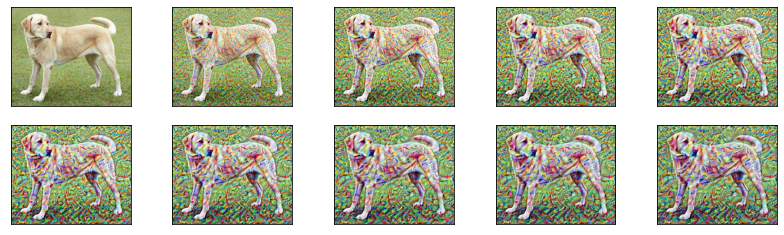

In [9]:
best, best_loss = MyModelResNet50.train_step()

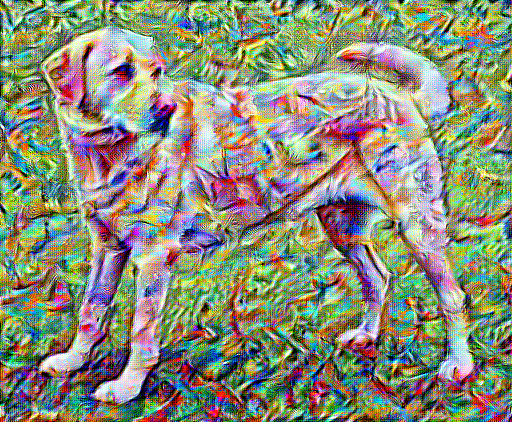

In [10]:
bestImage = Image.fromarray(best)
bestImage